In [1]:
from amuse.lab import *

In [2]:
# To reflect changes in file made outside of iPython notebook
%load_ext autoreload
%autoreload 2

In [3]:
# Enable showing plots inside iPython notebook
%matplotlib inline

In [4]:
try:
    from amuse import plot
    from matplotlib import pyplot
    IS_PLOT_AVAILABLE = True
except ImportError:
    IS_PLOT_AVAILABLE = False

In [5]:
from amuse.support.core import late

from amuse import io
from amuse.io import text
from amuse.units import constants
from amuse.units.generic_unit_converter import ConvertBetweenGenericAndSiUnits
from amuse.units.nbody_system import nbody_to_si
from amuse.units.quantities import VectorQuantity
from amuse.units.generic_unit_system import *

from amuse.community.athena.interface import Athena
from amuse.community.capreole.interface import Capreole
from amuse.community.mpiamrvac.interface import MpiAmrVac

from amuse.community.gadget2.interface import Gadget2
from amuse.community.fi.interface import Fi
from amuse.ext.grid_to_sph import convert_grid_to_SPH

import numpy

from numpy import sqrt, arange, searchsorted
from optparse import OptionParser

from amuse.datamodel import Grid
from amuse.datamodel import Particles
from amuse.datamodel.grids import SamplePointsOnMultipleGrids
from amuse.datamodel.grids import SamplePointWithIntepolation
from amuse.datamodel.grids import SamplePointOnCellCenter

In [6]:
from test_riemann_shock_tube_problem import CalculateExactSolutionIn1D
from test_riemann_shock_tube_problem import CalculateSolutionIn3D
from test_riemann_shock_tube_problem import store_attributes
from test_riemann_shock_tube_problem import store_attributes_of_line

In [7]:
def run_code(runtime, **options):
    print "\ncalculating shock using code {0}".format(options["name_of_the_code"])
    model = CalculateSolutionIn3D(**options)
    grids = model.get_solution_at_time(runtime | time)

    print "sampling grid"
    if model.name_of_the_code in model.sph_hydro_codes:
        samples = grids
    else:
        samplepoints = [(x, 0.5, 0.5) | length for x in numpy.linspace(0.0, 1.0, 2000)]
        # print len(grids)
        samples = SamplePointsOnMultipleGrids(grids, samplepoints, SamplePointOnCellCenter)
        # print len(samples)
        samples.filterout_duplicate_indices()
        # print len(samples)

    print "saving data"
    store_attributes(samples.x, samples.rho, samples.rhovx, samples.energy,
        filename="riemann_shock_tube_problem_{0}_{1}.csv".format(model.name_of_the_code, runtime))


if __name__ == '__main__':
    options = dict(number_of_grid_points = 10,
                   number_of_workers = 4,
                   name_of_the_code = "gadget2",
                   number_of_particles = 10000)
    
    # Simulation end time
    runtime = 0.12
    print "Runtime", runtime
    print "calculating shock using exact solution"
    exact = CalculateExactSolutionIn1D()
    xpositions, rho, p, u = exact.get_solution_at_time(runtime | time)
    print "saving data"
    store_attributes(xpositions, rho, u, p,
        filename="exact_riemann_shock_tube_problem_{0}.csv".format(runtime))

    for code in ["gadget2"]:#, "fi", "athena", "mpiamrvac", "capreole"]:
        options["name_of_the_code"] = code
        if code == "fi" or code == "athena":
            options["number_of_workers"] = 1 
        run_code(runtime, **options)
    print "Done..."

Runtime 0.12
calculating shock using exact solution
saving data

calculating shock using code gadget2
/net/glados2.science.uva.nl/api/thalbes1/amuse-10.0/data/gadget2/output
start evolve
copying results
terminating code
sampling grid
saving data
Done...


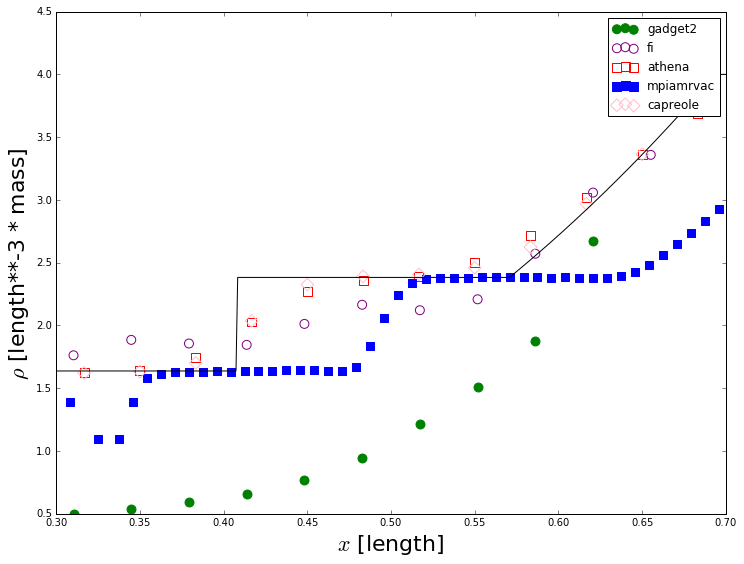

In [8]:
from ipywidgets import interact, SelectMultiple, FloatSlider, ToggleButtons
code_selection = SelectMultiple(options=["gadget2", "fi", "athena", "mpiamrvac", "capreole"],
                                selected_labels=["gadget2", "fi", "athena", "mpiamrvac", "capreole"])
runtime_slider = FloatSlider(min=0.0, max=0.6, step=0.06, value=0.12)
quantity_button = ToggleButtons(options=["Density", "Pressure", "Internal Energy", "Velocity", "Entropy"])

@interact(codes=code_selection, runtime=runtime_slider, quantity=quantity_button)
def plot_codes(codes, runtime, quantity):
    instance = text.CsvFileText("exact_riemann_shock_tube_problem_{0}.csv".format(runtime))
    samples = instance.load()
    quantities = {"Density": "rho", "Internal Energy": "energy"}
    # samples.x, samples.rho, samples.rhovx, samples.energy
    
    markersetup = {"gadget2": ("green", "green", "o", 80), 
                   "fi": ("none", "purple", "o", 80),
                   "athena": ("none", "red", "s", 80),
                   "mpiamrvac": ("blue", "blue", "s", 80),
                   "capreole": ("none", "pink", "D", 80)}

    fig = pyplot.figure(figsize=(12, 9))
    plot.plot(samples.x[::-1], getattr(samples, quantities[quantity]), c="black")
    for code in codes:
        filename="riemann_shock_tube_problem_{0}_{1}.csv".format(code, runtime)
        instance = text.CsvFileText(filename)
        samples = instance.load()
        # xpositions, rho, u, p
        face, edge, marker, size = markersetup.get(code)
        plot.scatter(samples.x[::-1], getattr(samples, quantities[quantity]), marker=marker, s=size,
                     facecolors=face, edgecolors=edge,
                     label="{0}".format(code))
    pyplot.xlim(0.3, 0.7)
    pyplot.ylim(0.5, 4.5)

    plot.xlabel(r'$x$', fontsize=22)
    plot.ylabel(r'$\rho$', fontsize=22)
    pyplot.legend()